# On Analyzing Real World Time Series for Forecasting Stock Data - Apple Returns Data
- TUTORIAL: [simplestockpredictionautoregression.ipynb](https://gist.github.com/DanielWicz/e2f90648e46da599080fed70d11cc09c)
- I also have the code in the play folder. Have my code resemble his.
- With splitting data
- The `MA` model is taking a while to run on the threshold lags, so I'm slicing to only consider the first X threshold lags.


## TODOs
- [ ] Update Follow-up section 

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, PersistenceWalkForward, AR, MA, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis with Forecasts

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2011-01-01", "2021-01-01"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("AAPL", "Apple"),
    ("INTC", "Intel")
]
independent_variable = "Close"
# frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = 'AAPL'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([ 11.77035713,  11.83178616,  11.92857075, ..., 134.86999512,
       133.72000122, 132.69000244])

In [6]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

,Close
Date,
2011-01-03,11.770357
2011-01-04,11.831786
2011-01-05,11.928571
2011-01-06,11.918929
2011-01-07,12.004286
...,...
2020-12-24,131.970001
2020-12-28,136.690002
2020-12-29,134.869995


### Plot Raw Data

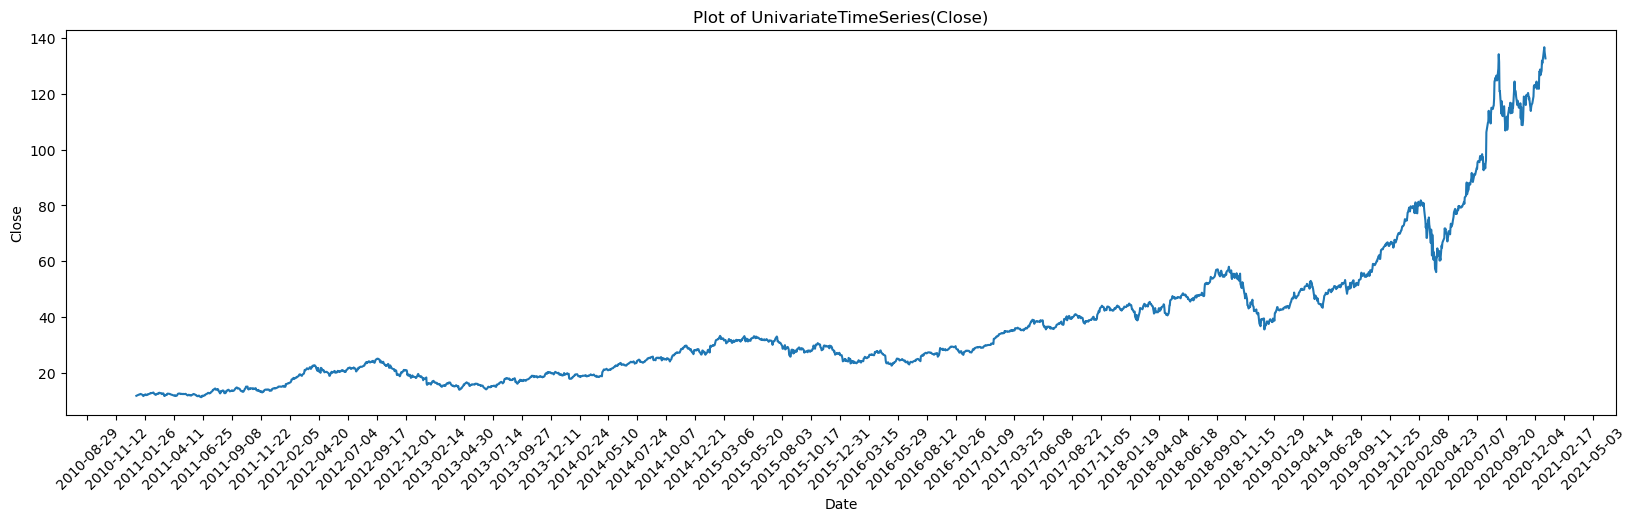

In [7]:
stocks[stock_symbol].plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [8]:
stocks[stock_symbol].get_statistics()

,Close
count,2517.000000
mean,36.230201
std,24.453886
min,11.261429
25%,19.609644
50%,28.262501
75%,43.970001
max,136.690002


In [9]:
stocks[stock_symbol].max_min_range()

{'Max': Close    136.690002
 dtype: float64,
 'Min': Close    11.261429
 dtype: float64,
 'Range': Close    125.428574
 dtype: float64}

In [10]:
stocks[stock_symbol].autocorrelation(3)

0.9875450100646932

- How come we don't use the partial ACorr values?

In [11]:
threshold_acorrs = stocks[stock_symbol].autocorrelation_with_threshold()
len(threshold_acorrs)

738

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [12]:
stocks[stock_symbol].stationarity_test(stock_df)

ADF Statistic: 3.302925
p-value: 1.000000 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

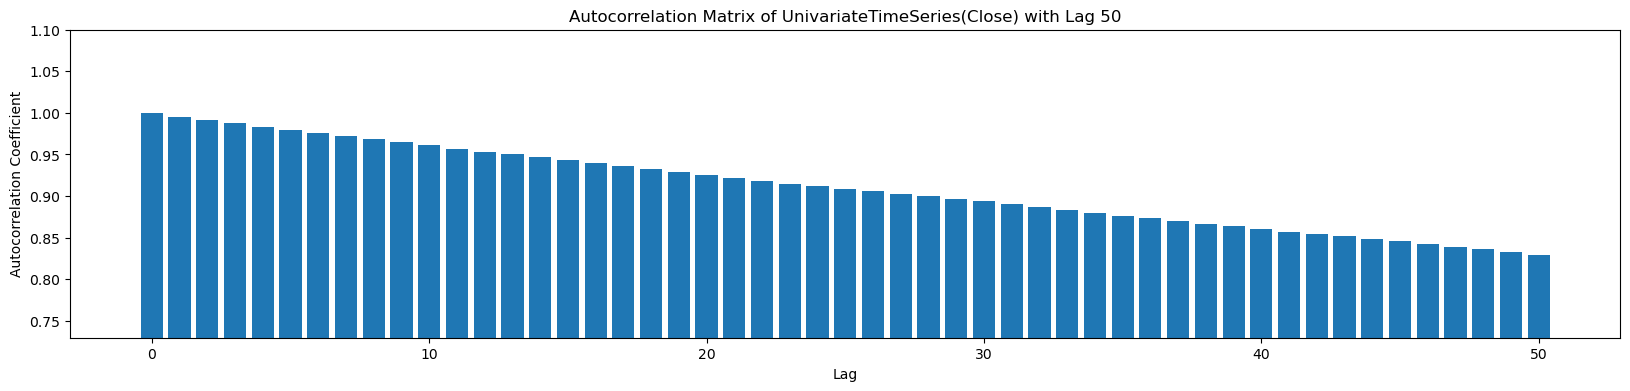

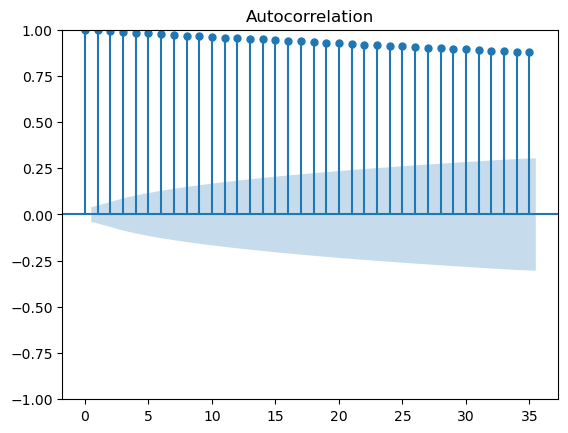

In [13]:
stocks[stock_symbol].plot_autocorrelation(50)

- Above, the data is highly correlated which means that the k-th lag observation has some impact on the most recent observation.

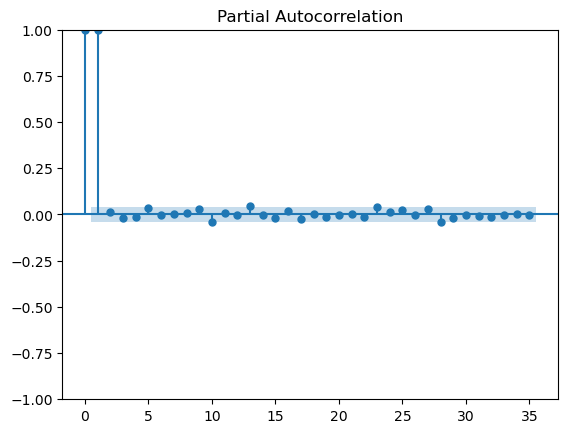

In [14]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

- Above, the data shows a rapid decay at lag 2. 

- The Partial ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with AR(1).

### Get Returns Data

In [15]:
len(stocks[stock_symbol].get_series()), stocks[stock_symbol].get_series()

(2517,
 array([ 11.77035713,  11.83178616,  11.92857075, ..., 134.86999512,
        133.72000122, 132.69000244]))

In [16]:
stock_returns = stocks[stock_symbol].data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

In [17]:
threshold_acorrs_for_returns = stock_returns.autocorrelation_with_threshold()
len(threshold_acorrs_for_returns), threshold_acorrs_for_returns

(0, [])

- We have 0 ACorr values above our threshold. What if we adjust the threshold?

In [18]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

,Returns
Date,
2011-01-04,0.005219
2011-01-05,0.008180
2011-01-06,-0.000808
2011-01-07,0.007161
2011-01-10,0.018833
...,...
2020-12-24,0.007712
2020-12-28,0.035766
2020-12-29,-0.013315


### Plot Returns

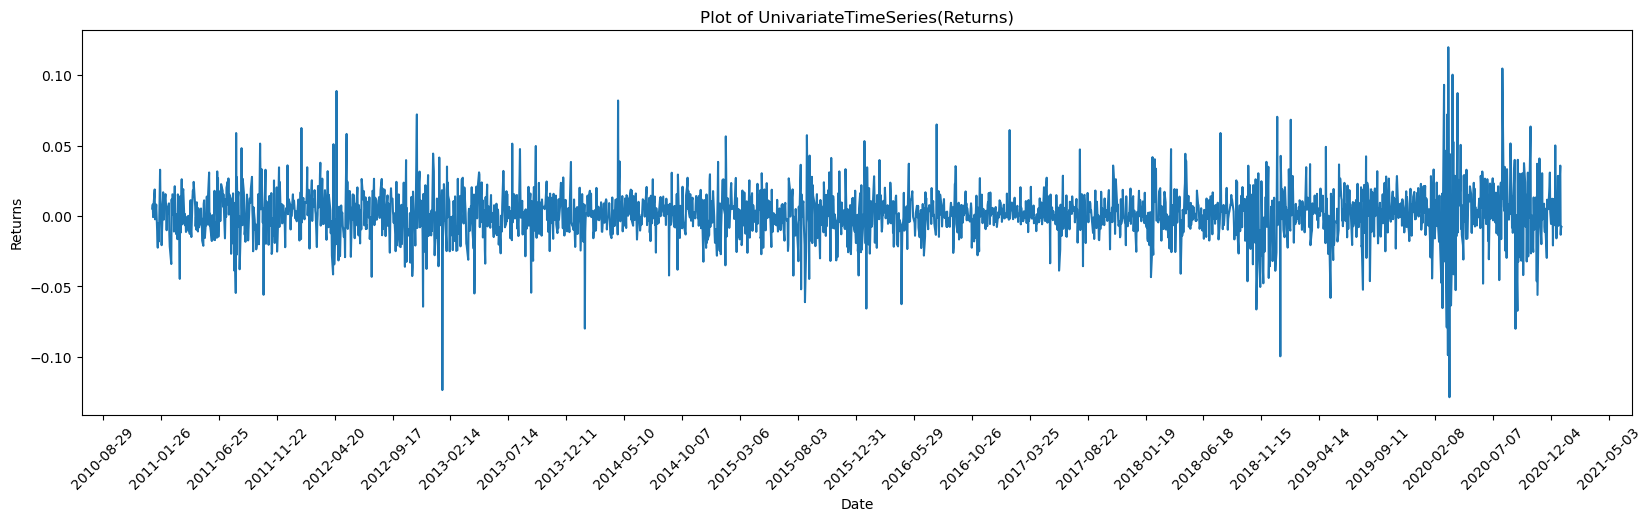

In [19]:
stock_returns.plot(tick_skip=150)

- Returns seem to have constant mean and constant although there are a few funnel like shape

### Get Descriptive Statistics of Returns Data

In [20]:
stock_returns.get_statistics()

,Returns
count,2516.000000
mean,0.001124
std,0.017938
min,-0.128647
25%,-0.007150
50%,0.000833
75%,0.010320
max,0.119808


### Check Stationarity of Returns Data

In [21]:
stock_returns.stationarity_test(stock_returns_df)

ADF Statistic: -9.946406
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

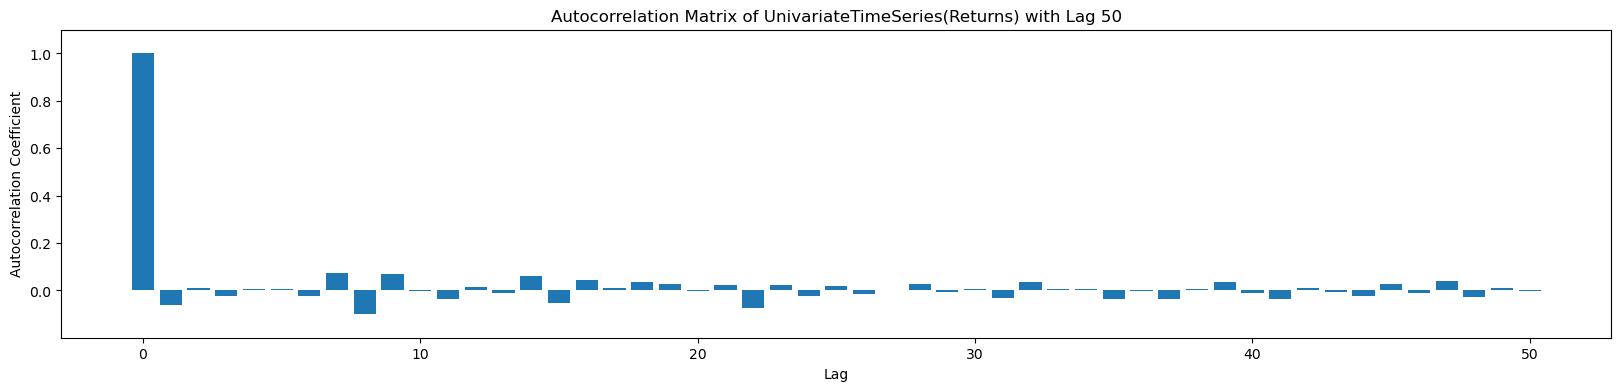

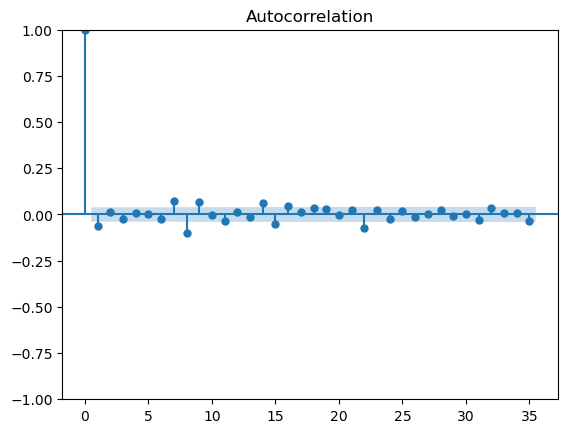

In [22]:
stock_returns.plot_autocorrelation(50)

- Lag exponentially decays at 1, thus we'd only want to use lag 2?

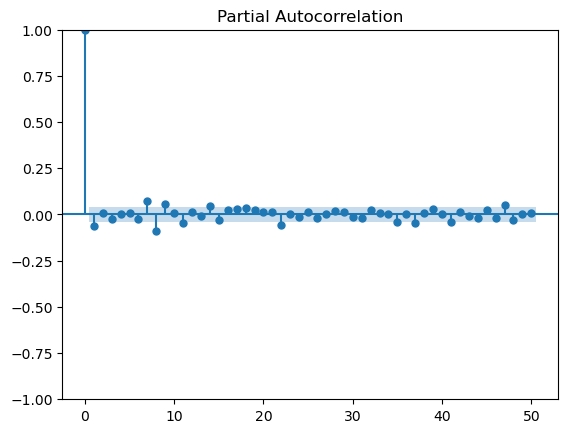

In [23]:
stock_returns.plot_partial_autocorrelation(50)

### Initialize Autoregressive AR(p) Model

- How to determine the proper lag value? Look at the Partial ACor plot.

In [24]:
days_to_forecast = [10, 366]

for i in range(len(days_to_forecast)):
    total_days = len(stock_returns)
    print(f'Total days {total_days}')
    
    test_days = days_to_forecast[i]
    print(f'Test days considered {test_days}')
    
    training_days = total_days - test_days
    print(f'Training days considered {training_days}\n')

Total days 2516
Test days considered 10
Training days considered 2506

Total days 2516
Test days considered 366
Training days considered 2150



In [25]:
import warnings
warnings.filterwarnings('ignore')

- `threshold_acorrs` vs `threshold_acorrs_for_returns`

In [26]:
train_labels = []
true_labels = []

# New model for each new X day forecast
trained_ar_models = []

for i in range(len(days_to_forecast)):
    print(f'{days_to_forecast[i]} Day Forecast')
    
    train_data = stock_returns.get_as_df()[:-days_to_forecast[i]]
    print(f'Length of training days {len(train_data)}')
    # print(train_data)
    train_labels.append(train_data)
    
    true_data = stock_returns.get_as_df()[-days_to_forecast[i]:]
    print(f'Length of testing days {len(true_data)}')
    # print(true_labels) 
    true_labels.append(true_data)
    
    # create objects from the AR() and MA() classes, respectively
    ar_model_class = AR()

    # call functions to train our AR and MA models, respectively
    trained_ar_model = ar_model_class.train_ar_model(train_data, threshold_acorrs[:50])
    
    # can't use threshold_acorrs_for_returns because it's empty 
    # trained_ar_model = ar_model_class.train_ar_model(train_data, threshold_acorrs_for_returns)
    print(f'{days_to_forecast[i]} Day Forecast Model: {trained_ar_model}\n')
    
    trained_ar_models.append(trained_ar_model)

10 Day Forecast
Length of training days 2506
Length of testing days 10
10 Day Forecast Model: <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a1797550>

366 Day Forecast
Length of training days 2150
Length of testing days 366
366 Day Forecast Model: <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a184feb0>



In [27]:
# threshold_acorrs[:50]

### Predict + Plot Actual Forecasts vs Predicted Forecasts for Raw Data

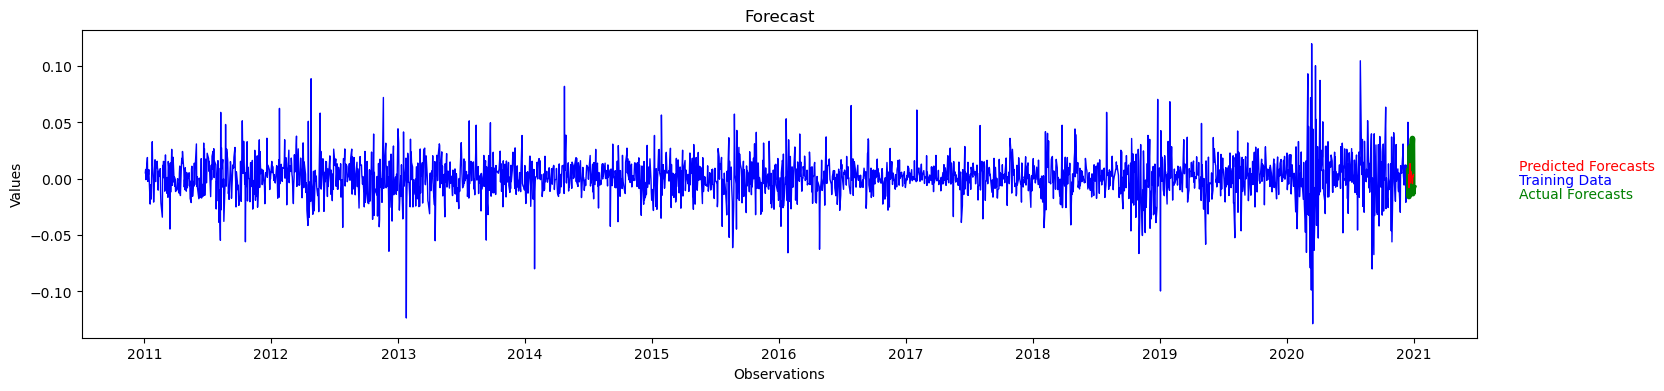

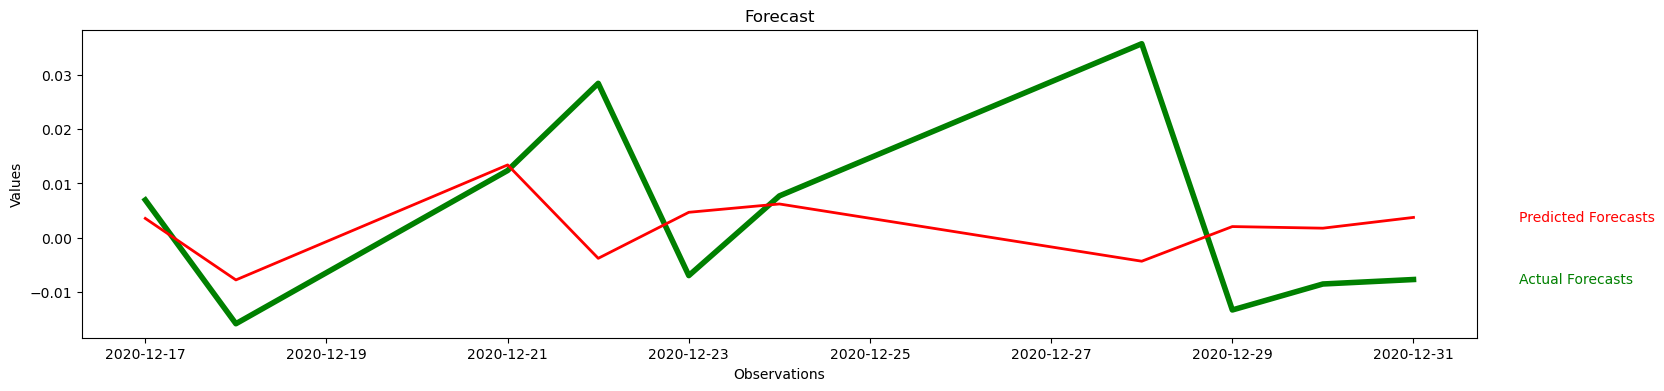

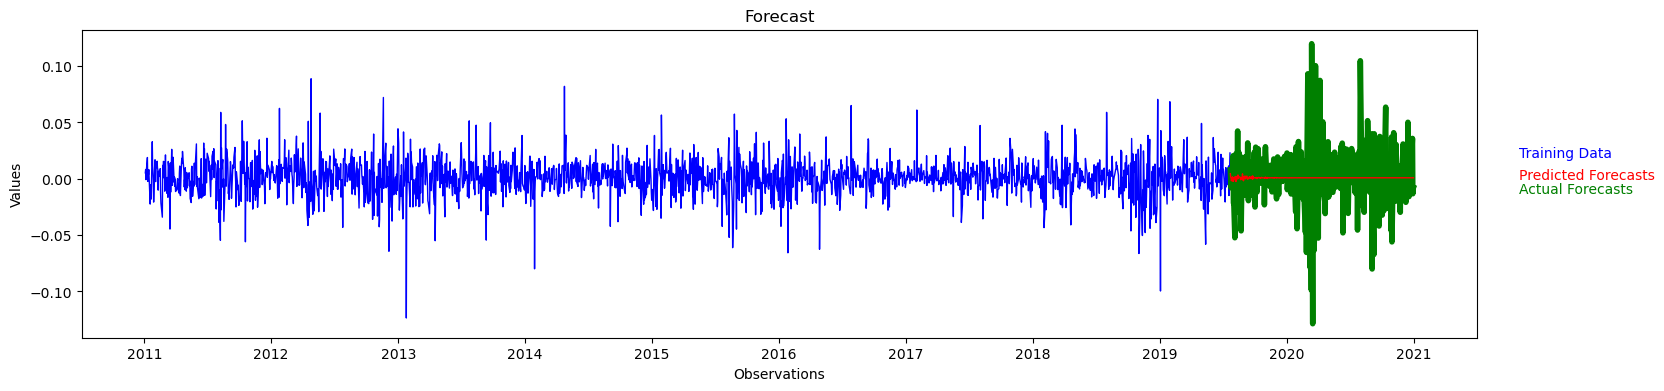

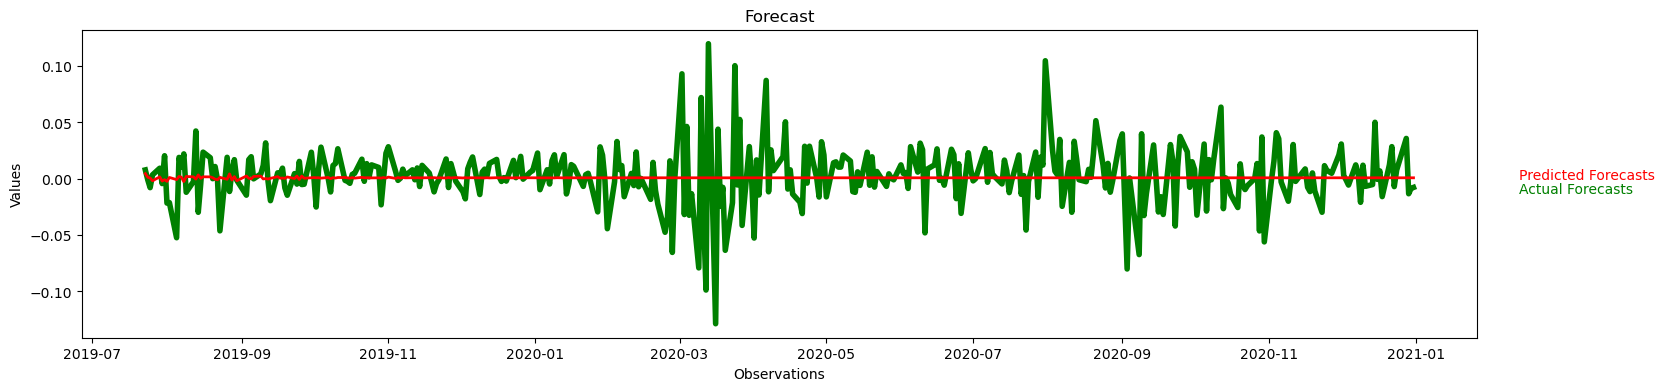

In [28]:
# New forecasting model for each new X day forecast
ar_forecasts = []

for i in range(len(trained_ar_models)):
    ar_forecast = ar_model_class.predict(trained_ar_models[i], train_labels[i], true_labels[i])
    ar_forecasts.append(ar_forecast)
    # print(f'{days_to_forecast[i]} Day Forecasts: \n{ar_forecast}')
    
    EvaluationMetric.plot_forecast(train_labels[i], true_labels[i], ar_forecast)
    EvaluationMetric.plot_forecast_only(true_labels[i], ar_forecast)
    
    print("\n")

In [29]:
for i in range(len(ar_forecasts)):
    ar_forecast_for_specific_model = ar_forecasts[i]
    # print(i, type(ar_forecast_for_specific_model), "\n", ar_forecast_for_specific_model)
    
    # Get evaluation metrics
    EvaluationMetric.eval_mse(true_labels[i], ar_forecast_for_specific_model)
    
    EvaluationMetric.eval_rmse(true_labels[i], ar_forecast_for_specific_model)
    print()

Test MSE: 0.000
Test RMSE: 0.018

Test MSE: 0.001
Test RMSE: 0.026



In [30]:
train_labels = []
true_labels = []

# New model for each new X day forecast
trained_ma_models = [] 

for i in range(len(days_to_forecast)):
    print(f'{days_to_forecast[i]} Day Forecast')
    
    train_data = stock_returns.get_as_df()[:-days_to_forecast[i]]
    print(f'Length of training days {len(train_data)}')
    # print(train_data)
    train_labels.append(train_data)
    
    true_data = stock_returns.get_as_df()[-days_to_forecast[i]:]
    print(f'Length of testing days {len(true_data)}')
    # print(true_labels) 
    true_labels.append(true_data)
    
    # create objects from the AR() and MA() classes, respectively
    ma_model_class = MA()

    # call functions to train our AR and MA models, respectively
    trained_ma_model = ma_model_class.train_ma_model(train_data, threshold_acorrs[:50], 10)
    
    # can't use threshold_acorrs_for_returns because it's empty 
    # trained_ar_model = ar_model_class.train_ar_model(train_data, threshold_acorrs_for_returns)
    print(f'{days_to_forecast[i]} Day Forecast Model: {trained_ma_model}\n')
    
    trained_ma_models.append(trained_ma_model)

10 Day Forecast
Length of training days 2506
Length of testing days 10
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
10 Day Forecast Model: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a196a670>

366 Day Forecast
Length of training days 2150
Length of testing days 366
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
366 Day Forecast Model: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a196a7f0>



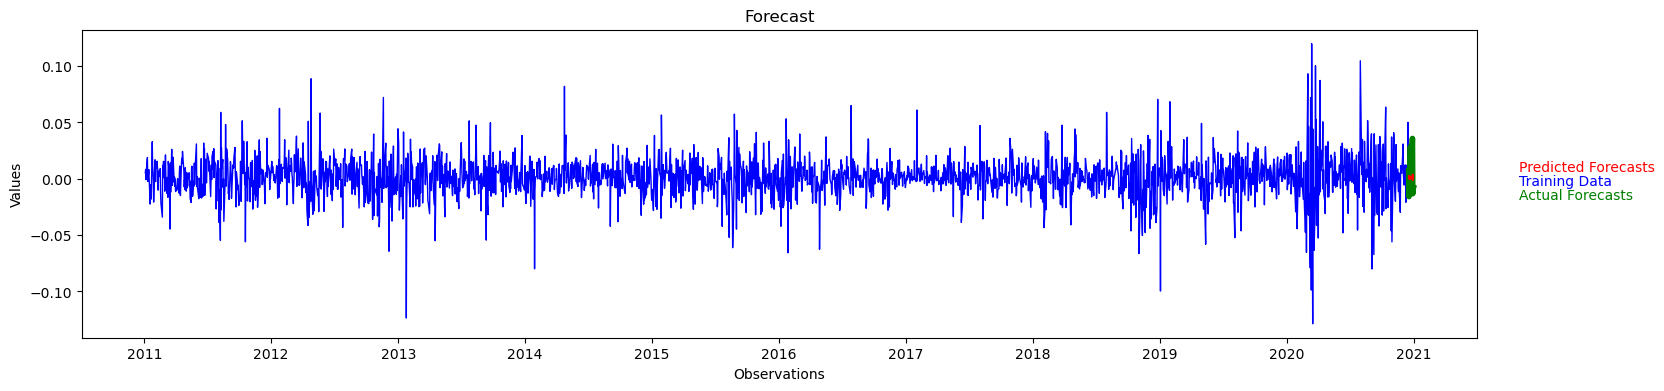

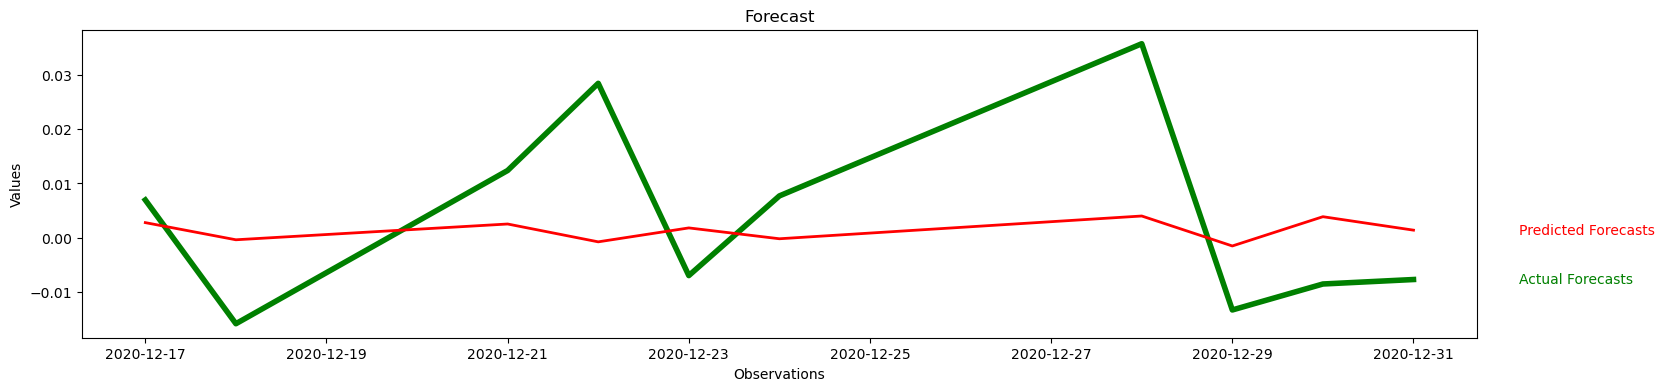

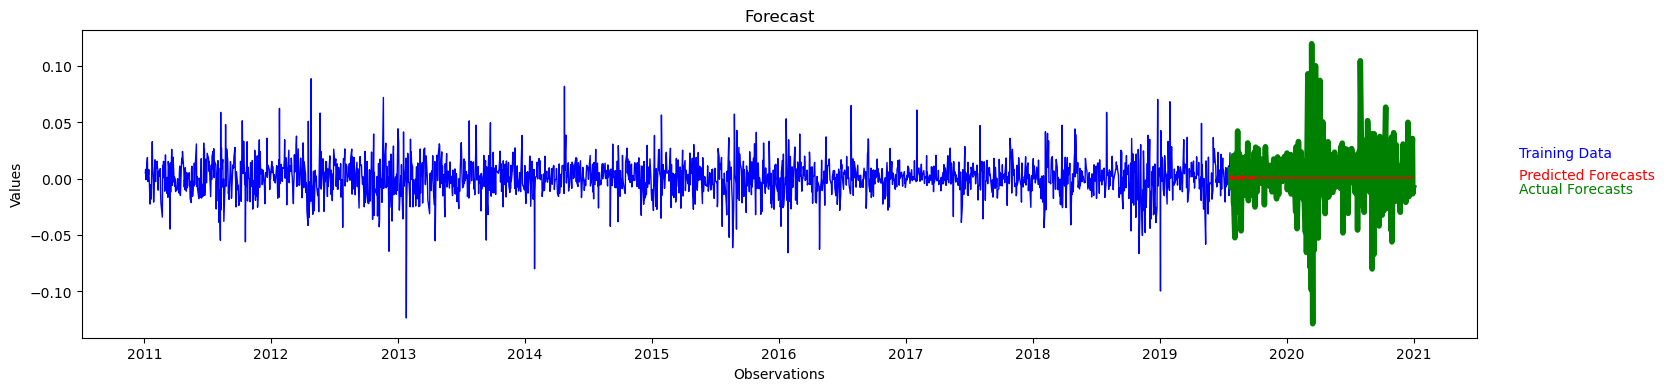

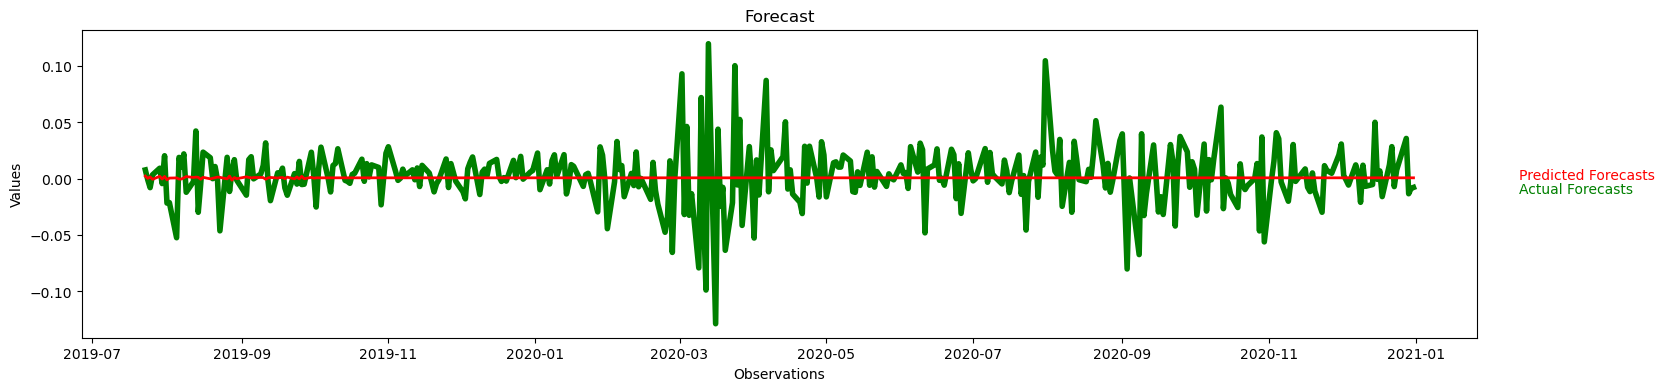

In [31]:
# New forecasting model for each new X day forecast
ma_forecasts = []

for i in range(len(trained_ma_models)):
    ma_forecast = ma_model_class.predict(trained_ma_models[i], train_labels[i], true_labels[i])
    ma_forecasts.append(ma_forecast)
    # print(f'{days_to_forecast[i]} Day Forecasts: \n{ma_forecast}')
    
    EvaluationMetric.plot_forecast(train_labels[i], true_labels[i], ma_forecast)
    EvaluationMetric.plot_forecast_only(true_labels[i], ma_forecast)
    
    print("\n")

In [32]:
for i in range(len(ma_forecasts)):
    ma_forecast_for_specific_model = ma_forecasts[i]
    # print(i, type(ar_forecast_for_specific_model), "\n", ma_forecast_for_specific_model)
    
    # Get evaluation metrics
    EvaluationMetric.eval_mse(true_labels[i], ma_forecast_for_specific_model)
    
    EvaluationMetric.eval_rmse(true_labels[i], ma_forecast_for_specific_model)
    print()

Test MSE: 0.000
Test RMSE: 0.017

Test MSE: 0.001
Test RMSE: 0.026



### Follow-up
- What can we determine from this?
    - 10 Day Forecast:
        - Actual Forecast (with the real prices): We'd want to buy on 2020-12-28 and sell on 2020-12-28.
        - Predicted Forecast (`AR` model): We'd want to by on 2020-12-18 and sell on 2020-12-21.
        - Predicted Forecast (`AR` model): We'd want to by on 2020-12-24 and sell on 2020-12-28.
- Can we do better? or Why might this be wrong?
    - We only consider AR. The data does NOT have multicollinearity [some of the lagged variables provide redundant information] bc we differenced to get the returns.
    - Our MSE and RMSE are lower compared to our `AR` when NOT differencing.
- What to consider?